In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "/content/drive/MyDrive/tflite_models/Master Folder/train"
data_dirs = "/content/drive/MyDrive/tflite_models/Master Folder/valid"

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print("hfklxnklfnb")

Found 1000 files belonging to 4 classes.
Using 800 files for training.
hfklxnklfnb


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dirs,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 36 files belonging to 4 classes.
Using 7 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Angry', 'Other', 'Sad', 'happy']


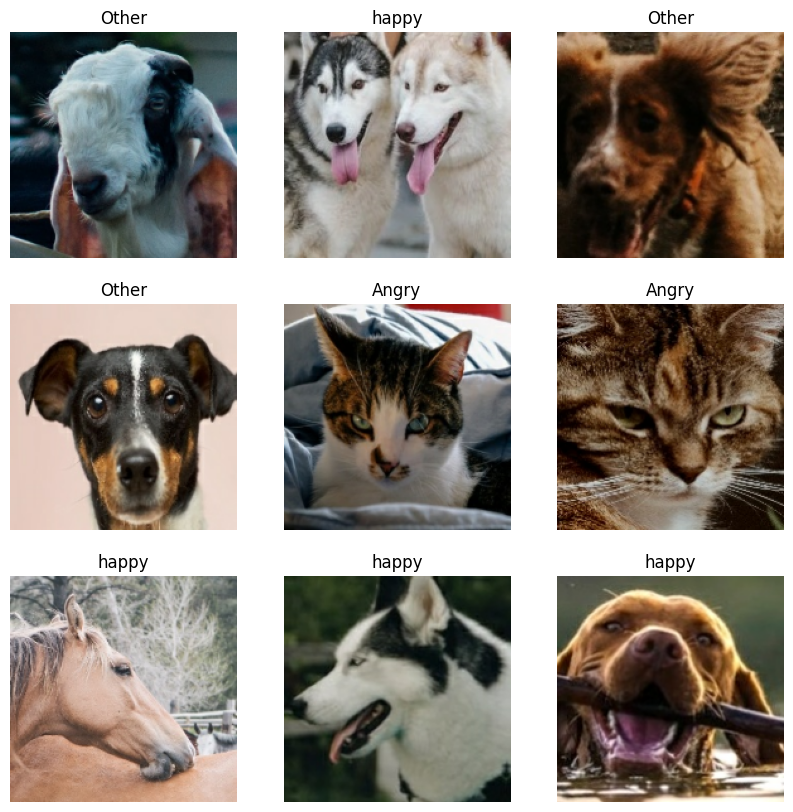

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0013568187 1.0


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:
epochs=1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/1000
25/25 [==============================] - 1s 31ms/step - loss: 3.2634e-08 - accuracy: 1.0000 - val_loss: 8.3771 - val_accuracy: 0.4286
Epoch 2/1000
25/25 [==============================] - 0s 19ms/step - loss: 3.3677e-08 - accuracy: 1.0000 - val_loss: 8.3862 - val_accuracy: 0.4286
Epoch 3/1000
25/25 [==============================] - 0s 19ms/step - loss: 3.2037e-08 - accuracy: 1.0000 - val_loss: 8.3882 - val_accuracy: 0.4286
Epoch 4/1000
25/25 [==============================] - 0s 19ms/step - loss: 3.2932e-08 - accuracy: 1.0000 - val_loss: 8.4226 - val_accuracy: 0.4286
Epoch 5/1000
25/25 [==============================] - 0s 19ms/step - loss: 3.4869e-08 - accuracy: 1.0000 - val_loss: 8.4225 - val_accuracy: 0.4286
Epoch 6/1000
25/25 [==============================] - 0s 19ms/step - loss: 3.3230e-08 - accuracy: 1.0000 - val_loss: 8.4477 - val_accuracy: 0.4286
Epoch 7/1000
25/25 [==============================] - 0s 19ms/step - loss: 3.3379e-08 - accuracy: 1.0000 - val_loss: 8

In [24]:
img = "/content/drive/MyDrive/tflite_models/Master Folder/valid/Angry/34.jpg"

img = tf.keras.utils.load_img(
    img, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 29ms/step
This image most likely belongs to Angry with a 73.34 percent confidence.


In [27]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/tflite_models/Master Folder/test",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 38 files belonging to 4 classes.
Using 31 files for training.


In [28]:
model.evaluate(test_ds, return_dict=True)

1/1 [==============================] - 3s 3s/step - loss: 10.6944 - accuracy: 0.2903


{'loss': 10.694360733032227, 'accuracy': 0.29032257199287415}

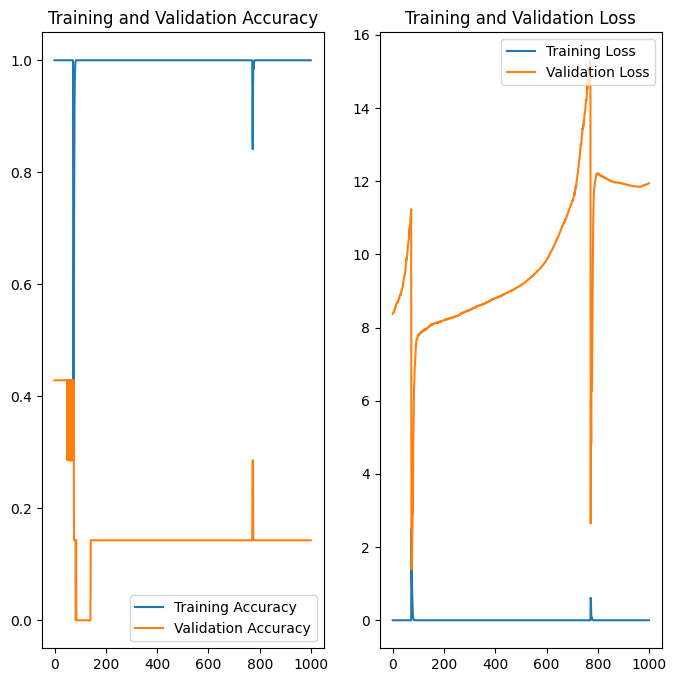

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()